# Extract barrier island metrics along transects

Author: Emily Sturdivant, esturdivant@usgs.gov

***

Extract barrier island metrics along transects for Barrier Island Geomorphology Bayesian Network. See the project [README](https://github.com/esturdivant-usgs/BI-geomorph-extraction/blob/master/README.md) and the Methods Report (Zeigler et al., in review). 


## Pre-requisites:
- All the input layers (transects, shoreline, etc.) must be ready. This is performed with the notebook file prepper.ipynb.
- The files servars.py and configmap.py may need to be updated for the current dataset.

## Notes:
- This notebook includes interactive quality checking, which requires the user's attention. For thorough QC'ing, we recommend displaying the layers in ArcGIS, especially to confirm the integrity of values for variables such as distance to inlet (__Dist2Inlet__) and widths of the landmass (__WidthPart__, etc.). 


***

## Import modules

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import arcpy
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import core.functions_warcpy as fwa
import core.functions as fun

### Initialize variables

Change the filename variables to match your local files. They should be in a Esri file geodatabase named site+year.gdb in your project directory, which will be the value of the variable `home`. You probably created some of them with `prepper.ipynb`.

Input the site, year, and project directory path. `setvars.py` retrieves the pre-determined values for that site in that year from `configmap.py`. The project directory will be used to set up your workspace. It's hidden for security – sorry! I recommend that you type the path somewhere and paste it in.

In [2]:
from core.setvars import *

extendedTrans = os.path.join(home, 'extTrans')
extTrans_tidy = os.path.join(home, 'extTrans')

ShorelinePts = os.path.join(home, 'Cobb2014_SLpts')
dlPts = os.path.join(home, 'Cobb2014_DLpts_utm')
dhPts = os.path.join(home, 'Cobb2014_DHpts_utm')

barrierBoundary = os.path.join(home, 'Cobb2014_bndpoly_2slman')  
# shoreline = os.path.join(home, 'ShoreBetweenInlets')

inletLines = os.path.join(home, 'Cobb2014_inletLines')

elevGrid = os.path.join(home, 'Cobb2014_DEM_5m')
# slopeGrid = os.path.join(home, 'slope_5m')   # Slope in 5 m grids
SubType = os.path.join(home, 'CoI14_SubType')
VegType = os.path.join(home, 'CoI14_VegType')
VegDens = os.path.join(home, 'CoI14_VegDen')
GeoSet = os.path.join(home, 'CoI14_GeoSet')
DisMOSH = os.path.join(home, 'CoI14_DisMOSH')

# tr_w_anthro = os.path.join(home, 'extTrans_wAnthro')

# Optional
# SA_bounds = ''
armorLines = os.path.join(home, 'blankarmor')

site (options: CapeLookout, Forsythe, Fisherman, Smith, Monomoy, CoastGuard, FireIsland, Rockaway, ParkerRiver, Cedar, Assateague, Cobb): Cobb
year (options: 2010, 2012, 2014): 2014
Path to project directory (e.g. \\Macolume\dir\FireIsland2014): ········
setvars.py initialized variables.


## Transect-averaged values
We work with the shapefile/feature class as a pandas DataFrame as much as possible to speed processing and minimize reliance on the ArcGIS GUI display.

1. Create a pandas dataframe from the transects feature class. In the process, we remove some of the unnecessary fields. The resulting dataframe is indexed by __sort_ID__ with columns corresponding to the attribute fields in the transects feature class. 
2. Add __DD_ID__.
3. Join the values from the transect file that includes the three anthropologic development fields, __Construction__,  __Development__, and __Nourishment__. 

In [3]:
# Copy feature class to dataframe.
trans_df = fwa.FCtoDF(extendedTrans, id_fld=tID_fld, extra_fields=extra_fields)
trans_df['DD_ID'] = trans_df[tID_fld] + sitevals['id_init_val']

# Get anthro fields and join to DF
if 'tr_w_anthro' in locals():
    trdf_anthro = fwa.FCtoDF(tr_w_anthro, id_fld=tID_fld, dffields=['Development', 'Nourishment','Construction'])
    trans_df = fun.join_columns(trans_df, trdf_anthro) 

# Save
trans_df.to_pickle(os.path.join(scratch_dir, 'trans_df.pkl'))

# Display
print("\nHeader of transects dataframe (rows 1-5 out of {}): ".format(len(trans_df)))
trans_df.head()

...converting feature class to array...
...converting array to dataframe...

Header of transects dataframe (rows 1-5 out of 205): 


,Azimuth,LRR,TransOrder,TransectId,sort_ID,DD_ID
sort_ID,,,,,,
1,NaN,NaN,NaN,NaN,1,160001
2,NaN,NaN,NaN,NaN,2,160002
3,NaN,NaN,NaN,NaN,3,160003
4,NaN,NaN,NaN,NaN,4,160004
5,NaN,NaN,NaN,NaN,5,160005


### Add XY and Z/slope from SL, DH, DL points within 25 m of transects
Add to each transect row the positions of the nearest pre-created beach geomorphic features (shoreline, dune toe, and dune crest).

#### Shoreline

The MHW shoreline easting and northing (__SL_x__, __SL_y__) are the coordinates of the intersection of the oceanside shoreline with the transect. Each transect is assigned the foreshore slope (__Bslope__) from the nearest shoreline point within 25 m. These values are populated for each transect as follows: 
1. get __SL_x__ and __SL_y__ at the point where the transect crosses the oceanside shoreline; 
2. find the closest shoreline point to the intersection point (must be within 25 m) and copy the slope value from the point to the transect in the field __Bslope__.

In [4]:
if not 'shoreline' in locals():
    shoreline = os.path.join(home, 'ShoreBetweenInlets') # will be created if it does not already exist
if not 'SA_bounds' in locals(): 
    SA_bounds = ''
shoreline = fwa.CreateShoreBetweenInlets(barrierBoundary, inletLines, shoreline, ShorelinePts, proj_code, SA_bounds)

# Get the XY position where transect crosses the oceanside shoreline
sl2trans_df = fwa.add_shorelinePts2Trans(extendedTrans, ShorelinePts, shoreline, 
                                         tID_fld, proximity=pt2trans_disttolerance)

# Save and print sample
sl2trans_df.to_pickle(os.path.join(scratch_dir, 'sl2trans.pkl'))
sl2trans_df.sample(5)

Splitting Cobb2014_bndpoly_2slman at inlets...
Preserving only those line segments that intersect shoreline points...
Dissolving the line to create ShoreBetweenInlets...

Matching shoreline points to transects...
Using field 'slope' as slope.
The projection of Cobb2014_SLpts was changed. The new file is Cobb2014_SLpts_utm.
...duration at transect 100: 0:0:36.4 seconds
...duration at transect 200: 0:1:4.3 seconds
Duration: 0:1:5.7 seconds


,SL_x,SL_y,Bslope
sort_ID,,,
80,432927.2820,4.130155e+06,-0.037325
133,434346.8217,4.132406e+06,-0.076135
155,NaN,NaN,NaN
174,NaN,NaN,NaN
83,433014.1631,4.130276e+06,-0.041993


#### Dune positions along transects

__DL_x__, __DL_y__, and __DL_z__ are the easting, northing, and elevation, respectively, of the nearest dune toe point within 25 meters of the transect. __DH_x__, __DH_y__, and __DH_z__ are the easting, northing, and elevation, respectively, of the nearest dune crest point within 25 meters. 

__DL_snapX__, __DL_snapY__, __DH_snapX__, and __DH_snapY__ are the eastings and northings of the points "snapped" to the transect. "Snapping" finds the position along the transect nearest to the point, i.e. orthogonal to the transect. These values are used to find the beach width. The elevation values are not snapped; we use the elevation values straight from the original points. 

These values are populated as follows: 

1. Find the nearest dune crest/toe point to the transect and proceed if the distance is less than 25 m. If there are no points within 25 m of the transect, populate the row with Null values.
2. Get the X, Y, and Z values of the point. 
3. Find the position along the transect of an orthogonal line drawn to the dune point (__DL_snapX__, __DL_snapY__, __DH_snapX__, and __DH_snapY__). This is considered the 'snapped' XY position and is calculated using the arcpy geometry method. 

In [5]:
# Create dataframe for both dune crest and dune toe positions
dune2trans_df = fwa.find_ClosestPt2Trans_snap(extendedTrans, dhPts, dlPts, trans_df, 
                                          tID_fld, proximity=pt2trans_disttolerance)

# Save and print sample
dune2trans_df.to_pickle(os.path.join(scratch_dir, 'dune2trans.pkl'))
dune2trans_df.sample(5)


Matching dune points with transects:
Using field 'dhigh_z' as DH Z field...
Using field 'dlow_z' as DL Z field...
Looping through transects and dune points to find nearest point within 25 m...
...duration at transect 100: 0:0:38.8 seconds
...duration at transect 200: 0:1:11.7 seconds
Duration: 0:1:13.3 seconds


,DH_x,DH_y,DH_z,DH_snapX,DH_snapY,DL_x,DL_y,DL_z,DL_snapX,DL_snapY
sort_ID,,,,,,,,,,
128,434223.4176,4.132180e+06,1.493508,434226.179500,4.132183e+06,NaN,NaN,NaN,NaN,NaN
65,432362.4307,4.129646e+06,2.096728,432360.910665,4.129644e+06,432377.066165,4.129630e+06,1.467972,432377.521190,4.129631e+06
102,433556.9995,4.131060e+06,1.465310,433555.839720,4.131058e+06,NaN,NaN,NaN,NaN,NaN
40,431563.2718,4.128687e+06,1.637443,431560.306430,4.128683e+06,NaN,NaN,NaN,NaN,NaN
62,432246.0646,4.129522e+06,2.370811,432256.507633,4.129535e+06,432253.812815,4.129513e+06,1.683241,432265.301453,4.129528e+06


#### Armoring
__Arm_x__, __Arm_y__, and __Arm_z__ are the easting, northing, and elevation, respectively, where an artificial structure crosses the transect in the vicinity of the beach. These features are meant to supplement the dune toe data set by providing an upper limit to the beach in areas where dune toe extraction was confounded by the presence of an artificial structure. Values are populated for each transect as follows: 

1. Get the positions of intersection between the digitized armoring lines and the transects (Intersect tool from the Overlay toolset); 
2. Extract the elevation value at each intersection point from the DEM (Extract Multi Values to Points tool from Spatial Analyst); 

In [6]:
# Create elevation raster at 5-m resolution if not already
elevGrid = fwa.ProcessDEM(elevGrid, utmSR)

# Armoring line
if 'armorLines' in locals():
    arm2trans_df = fwa.ArmorLineToTrans_PD(extendedTrans, armorLines, sl2trans_df, tID_fld, proj_code, elevGrid)

    # Save and print sample
    arm2trans_df.to_pickle(os.path.join(scratch_dir, 'arm2trans.pkl'))
    try:
        arm2trans_df.sample(5)
    except:
        pass

OUTPUT: Cobb2014_DEM_5m_5m at 5x5 resolution.

Armoring file either missing or empty so we will proceed without armoring data. If shorefront tampering is present at this site, cancel the operations to digitize.


### Add all the positions to the trans_df
Join the new dataframes to the transect dataframe. Before it performs the join, `join_columns_id_check()` checks the index and the ID field for potential errors such as whether they are the equal and whether there are duplicated IDs or null values in either.

In [7]:
# Load saved dataframes
trans_df = pd.read_pickle(os.path.join(scratch_dir, 'trans_df.pkl'))
sl2trans_df = pd.read_pickle(os.path.join(scratch_dir, 'sl2trans.pkl'))
dune2trans_df = pd.read_pickle(os.path.join(scratch_dir, 'dune2trans.pkl'))
arm2trans_df = pd.read_pickle(os.path.join(scratch_dir, 'arm2trans.pkl'))

In [8]:
# Join positions of shoreline, dune crest, dune toe, armoring
trans_df = fun.join_columns_id_check(trans_df, sl2trans_df, tID_fld)
trans_df = fun.join_columns_id_check(trans_df, dune2trans_df, tID_fld)
if 'armorLines' in locals():
    trans_df = fun.join_columns_id_check(trans_df, arm2trans_df, tID_fld)

# Save and print sample
trans_df.to_pickle(os.path.join(scratch_dir, 'trans_df_beachmetrics.pkl'))
trans_df.sample(5)

,Azimuth,LRR,TransOrder,TransectId,DD_ID,SL_x,SL_y,Bslope,DH_x,DH_y,...,DH_snapX,DH_snapY,DL_x,DL_y,DL_z,DL_snapX,DL_snapY,Arm_x,Arm_y,Arm_z
sort_ID,,,,,,,,,,,,,,,,,,,,,
129,307.74,0.60,129.0,5532.0,160129,434255.4410,4.132224e+06,-0.075871,434246.2752,4.132225e+06,...,434249.015165,4.132229e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,307.74,-4.38,50.0,5453.0,160050,431955.0773,4.129010e+06,-0.017879,431795.9193,4.129139e+06,...,431793.033492,4.129135e+06,431818.665912,4.129129e+06,1.405339,431811.822103,4.129120e+06,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,160007,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,160016,430561.8312,4.127938e+06,-0.016869,430435.7476,4.128037e+06,...,430434.954120,4.128036e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,307.74,-2.81,89.0,5492.0,160089,433192.6570,4.130518e+06,-0.041804,433172.1906,4.130536e+06,...,433171.056162,4.130534e+06,433179.938822,4.130528e+06,1.308011,433179.849964,4.130528e+06,NaN,NaN,NaN


### Check for errors
*Optional*

Display summary stats / histograms and create feature classes. The feature classes display the locations that will be used to calculate beach width. Review the output feature classes in a GIS to validate. 

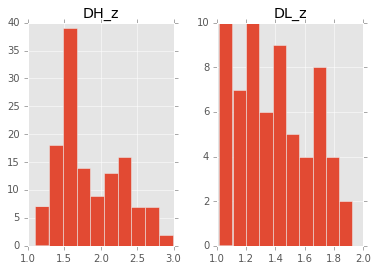

In [9]:
try:
    trans_df.hist(['DH_z', 'DL_z', 'Arm_z'])
    plt.show()
    plt.close()
except:
    pass

In [10]:
# Convert dataframe to feature class - shoreline points with slope
fwa.DFtoFC(sl2trans_df, os.path.join(arcpy.env.scratchGDB, 'pts2trans_SL'), 
           spatial_ref=utmSR, id_fld=tID_fld, xy=["SL_x", "SL_y"], keep_fields=['Bslope'])
print('OUTPUT: pts2trans_SL in designated scratch geodatabase.')

# Dune crests
try:
    fwa.DFtoFC(dune2trans_df, os.path.join(arcpy.env.scratchGDB, 'ptSnap2trans_DH'), 
               spatial_ref=utmSR, id_fld=tID_fld, xy=["DH_snapX", "DH_snapY"], keep_fields=['DH_z'])
    print('OUTPUT: ptSnap2trans_DH in designated scratch geodatabase.')
except Exception as err:
    print(err)
    pass

# Dune toes
try:
    fwa.DFtoFC(dune2trans_df, os.path.join(arcpy.env.scratchGDB, 'ptSnap2trans_DL'), 
               spatial_ref=utmSR, id_fld=tID_fld, xy=["DL_snapX", "DL_snapY"], keep_fields=['DL_z'])
    print('OUTPUT: ptSnap2trans_DL in designated scratch geodatabase.')
except Exception as err:
    print(err)
    pass

... converting dataframe to array... 
... converting array to feature class... 

OUTPUT: pts2trans_SL in designated scratch geodatabase.
... converting dataframe to array... 
... converting array to feature class... 

OUTPUT: ptSnap2trans_DH in designated scratch geodatabase.
... converting dataframe to array... 
... converting array to feature class... 

OUTPUT: ptSnap2trans_DL in designated scratch geodatabase.


### Calculate upper beach width and height
Upper beach width (__uBW__) and upper beach height (__uBH__) are calculated based on the difference in position between two points: the position of MHW along the transect (__SL_x__, __SL_y__) and the dune toe position or equivalent (usually __DL_snapX__, __DL_snapY__).  In some cases, the dune toe is not appropriate to designate the "top of beach" so beach width and height are calculated from either the position of the dune toe, the dune crest, or the base of an armoring structure. The dune crest was only considered a possibility if the dune crest elevation (__DH_zMHW__) was less than or equal to `maxDH`. 

They are calculated as follows: 
2. Calculate distances from MHW to the position along the transect of the dune toe (__DistDL__), dune crest (__DistDH__), and armoring (__DistArm__). 
2. Adjust the elevations to MHW, populating fields __DH_zmhw__, __DL_zmhw__, and __Arm_zmhw__. 
3. Conditionally select the appropriate feature to represent "top of beach." Dune toe is prioritized. If it is not available and __DH_zmhw__ is less than or equal to maxDH, use dune crest. If neither of the dune positions satisfy the conditions and an armoring feature intersects with the transect, use the armoring position. If none of the three are possible, __uBW__ and __uBH__ will be null. 
4. Copy the distance to shoreline and height above MHW (__Dist--__, __---zmhw__) to __uBW__ and __uBH__, respectively. 

Notes:
- In some morphology datasets, missing elevation values at a point indicate that the point should not be used to measure beach width. In those cases, use the `skip_missing_z` argument to select whether or not to skip these points. 

In [11]:
# Load saved dataframe
trans_df = pd.read_pickle(os.path.join(scratch_dir, 'trans_df_beachmetrics.pkl'))

In [12]:
# Calculate distances from shore to dunes, etc.
trans_df  = fwa.calc_BeachWidth_fill(extendedTrans, trans_df, maxDH, tID_fld, 
                                     sitevals['MHW'], fill, skip_missing_z=True)

Fields uBW and uBH populated with beach width and beach height.


### Dist2Inlet


Distance to nearest tidal inlet (__Dist2Inlet__) is computed as alongshore distance of each sampling transect from the nearest tidal inlet. This distance includes changes in the path of the shoreline instead of simply a Euclidean distance and reflects sediment transport pathways. It is measured using the oceanside shoreline between inlets (ShoreBetweenInlets). 

Note that the ShoreBetweenInlets feature class must be both 'dissolved' and 'singlepart' so that each feature represents one-and-only-one shoreline that runs the entire distance between two inlets or equivalent. If the shoreline is bounded on both sides by an inlet, measure the distance to both and assign the minimum distance of the two. If the shoreline meets only one inlet (meaning the study area ends before the island ends), use the distance to the only inlet. 

The process uses the cut, disjoint, and length geometry methods and properties in ArcPy data access module. The function measure_Dist2Inlet() prints a warning when the difference in Dist2Inlet between two consecutive transects is greater than 300. 

In [13]:
# Calc Dist2Inlet in new dataframe 
dist_df = fwa.measure_Dist2Inlet(shoreline, extendedTrans, inletLines, tID_fld)

# Join to transects
trans_df = fun.join_columns_id_check(trans_df, dist_df, tID_fld, fill=fill)

# Save and view last 10 rows
dist_df.to_pickle(os.path.join(scratch_dir, 'dist2inlet_df.pkl'))
dist_df.tail(10)

Duration: 0:0:2.5 seconds


,Dist2Inlet
sort_ID,
143.0,601.880202
144.0,549.964243
145.0,498.562341
146.0,446.626867
147.0,394.313022
148.0,342.516069
149.0,290.121981
150.0,235.958117
151.0,177.391318


### Clip transects, get barrier widths
Calculates __WidthLand__, __WidthFull__, and __WidthPart__, which measure different flavors of the cross-shore width of the barrier island. __WidthLand__ is the above-water distance between the back-barrier and seaward MHW shorelines. __WidthLand__ only includes regions of the barrier within the shoreline polygon (bndpoly_2sl) and does not extend into any of the sinuous or intervening back-barrier waterways and islands. __WidthFull__ is the total distance between the back-barrier and seaward MHW shorelines (including space occupied by waterways). __WidthPart__ is the width of only the most seaward portion of land within the shoreline. 

These are calculated as follows: 

1. Clip the transect to the full island shoreline (Clip in the Analysis toolbox); 
2. For __WidthLand__, get the length of the multipart line segment from &quot;SHAPE@LENGTH&quot; feature class attribute. When the feature is multipart, this will include only the remaining portions of the transect; 
3. For __WidthPart__, convert the clipped transect from multipart to singlepart and get the length of the first line segment, which should be the most seaward; 
4. For __WidthFull__, calculate the distance between the first vertex and the last vertex of the clipped transect (Feature Class to NumPy Array with explode to points, pandas groupby, numpy hypot).

In [25]:
# Clip transects, get barrier widths
widths_df = fwa.calc_IslandWidths(extendedTrans, barrierBoundary, tID_fld=tID_fld)

# # Save
widths_df.to_pickle(os.path.join(scratch_dir, 'widths_df.pkl'))

# Join
trans_df = fun.join_columns_id_check(trans_df, widths_df, tID_fld, fill=fill)

# Save
trans_df.to_pickle(os.path.join(scratch_dir, trans_name+'_null_prePts.pkl'))
trans_df.sample(5)

Clipping the transects to the barrier island boundaries ('clip2island')...
Getting the width along each transect of the oceanside land (WidthPart)...
...converting feature class to array...
...converting array to dataframe...
Getting the width along each transect of the entire barrier (WidthFull)...
Converting feature class vertices to array with X and Y...
...converting array to dataframe...
Getting the width along each transect of above water portion of the barrier (WidthLand)...


,Azimuth,LRR,TransOrder,TransectId,DD_ID,SL_x,SL_y,Bslope,DH_x,DH_y,...,DistArm,uBW,uBH,ub_feat,Dist2Inlet,mean_Zmhw,max_Zmhw,WidthFull,WidthLand,WidthPart
sort_ID,,,,,,,,,,,,,,,,,,,,,
96,307.74,-1.96,96.0,5499.0,160096,433385.2466,4.130811e+06,-0.069382,433328.7998,4.130850e+06,...,NaN,8.886061,0.943997,DL,3076.106154,-0.143567,1.615435,850.054035,850.054035,850.054035
186,NaN,NaN,NaN,NaN,160186,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,NaN,NaN,NaN,NaN,160076,432817.1400,4.129988e+06,-0.037650,432737.0860,4.130050e+06,...,NaN,74.227824,1.076916,DL,4077.788284,0.865606,2.161804,193.927733,193.927733,193.927733
109,307.74,-0.30,109.0,5512.0,160109,433777.9692,4.131329e+06,-0.004313,433746.6861,4.131354e+06,...,NaN,9.993160,0.723691,DL,2404.906007,0.020482,1.572446,606.436152,606.436152,606.436152
2,NaN,NaN,NaN,NaN,160002,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 5-m Points
The point dataset samples the land every 5 m along each shore-normal transect. 

### Split transects into points at 5-m intervals. 

The point dataset is created from the tidied transects (tidyTrans, created during pre-processing) as follows: 

1. Clip the tidied transects (tidyTrans) to the shoreline polygon (bndpoly_2sl) , retaining only those portions of the transects that represent land.
2. Produce a dataframe of point positions along each transect every 5 m starting from the ocean-side shoreline. This uses the positionAlongLine geometry method accessed with a Search Cursor and saves the outputs in a new dataframe. 
3. Create a point feature class from the dataframe. 

In [26]:
pts_df, pts_presort = fwa.TransectsToPointsDF(extTrans_tidy, barrierBoundary, 
                                              fc_out=os.path.join(arcpy.env.scratchGDB, 'transPts_unsorted'))

Clipping transects to within the shoreline bounds ('tidytrans_clipped')...
Getting points every 5m along each transect and saving in new dataframe...
Converting dataframe to feature class ('transPts_unsorted')...
... converting dataframe to array... 
... converting array to feature class... 


RuntimeError: table '\\Mac\stor\Projects\DeepDive\TransectExtraction\Cobb2014\scratch.gdb\transPts_unsorted' Exists

### Add Elevation and Slope to points

__ptZ__ (later __ptZmhw__) and __ptSlp__ are the elevation and slope at the 5-m cell corresponding to the point. 
1. Create the slope and DEM rasters if they don't already exist. We use the 5-m DEM to generate a slope surface (Slope tool in 3D Analyst). 
2. Use Extract Multi Values to Points tool in Spatial Analyst. 
3. Convert the feature class back to a dataframe.

In [27]:
# Create slope raster from DEM
if not 'slopeGrid' in locals():
    slopeGrid = os.path.join(home, 'slope_5m')   # Slope in 5 m grids; will be created
    if not arcpy.Exists(slopeGrid):
        arcpy.Slope_3d(elevGrid, slopeGrid, 'PERCENT_RISE')
    
# Add elevation and slope values at points.
arcpy.sa.ExtractMultiValuesToPoints(pts_presort, [[elevGrid, 'ptZ'], [slopeGrid, 'ptSlp']])

<geoprocessing server result object at 0x12755990>

In [28]:
if 'SubType' in locals():
    # Add substrate type, geomorphic setting, veg type, veg density values at points.
    arcpy.sa.ExtractMultiValuesToPoints(pts_presort, [[SubType, 'SubType'], [VegType, 'VegType'], 
                                                           [VegDens, 'VegDens'], [GeoSet, 'GeoSet'],
                                                            [DisMOSH, 'DisMOSH']])

    # Convert to dataframe
    pts_df = fwa.FCtoDF(pts_presort, xy=True, dffields=[tID_fld,'ptZ', 'ptSlp', 'SubType', 
                                                             'VegType', 'VegDens', 'GeoSet','DisMOSH'])
    # Recode fill values
    pts_df.replace({'GeoSet': {9999:np.nan}, 'SubType': {9999:np.nan}, 'VegType': {9999:np.nan},
                    'VegDens': {9999:np.nan}, 'DisMOSH': {9999:np.nan}}, inplace=True)
else:
    print("Plover BN layers not specified (we only check for SubType), so we'll proceed without them. ")
# Save and view sample
pts_df.to_pickle(os.path.join(scratch_dir, 'pts_extractedvalues_presort.pkl'))
pts_df.sample(5)

Converting feature class to array with X and Y...
...converting array to dataframe...


,DisMOSH,GeoSet,SHAPE@X,SHAPE@Y,SubType,VegDens,VegType,ptSlp,ptZ,sort_ID
10993,518,1,431857.7483,4.128895e+06,4444.0,111.0,11,1.882351,0.305817,47.0
9490,99999,4,431605.1219,4.128964e+06,7777.0,888.0,88,1.059206,0.666475,45.0
2267,99999,6,433645.8177,4.131874e+06,3333.0,NaN,88,1.938823,0.194355,116.0
7915,99999,3,432356.0639,4.129774e+06,7777.0,888.0,88,3.476192,1.862226,67.0
11,99999,6,434354.0166,4.133033e+06,3333.0,NaN,88,0.520045,0.324373,143.0


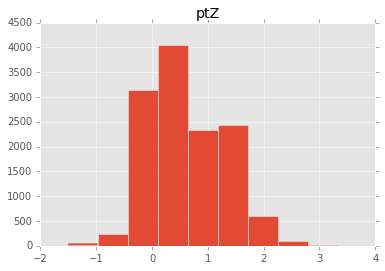

In [29]:
# Print histogram of elevation extracted to points
pts_df.hist('ptZ')
plt.show()
plt.close()

### Calculate distances and sort points

__SplitSort__ is a unique numeric identifier of the 5-m points at the study site, sorted by order along shoreline and by distance from oceanside. __SplitSort__ values are populated by sorting the points by __sort_ID__ and __Dist_Seg__ (see below). 

__Dist_Seg__ is the Euclidean distance between the point and the seaward shoreline (__SL_x__, __SL_y__). __Dist_MHWbay__ is the distance between the point and the bayside shoreline and is calculated by subtracting the __Dist_Seg__ value from the __WidthPart__ value of the transect. 

__DistSegDH__, __DistSegDL__, and __DistSegArm__ measure the distance of each 5-m point from the dune crest and dune toe position along a particular transect. They are calculated as the Euclidean distance between the 5-m point and the given feature. 

In [30]:
# Load saved dataframes
pts_df = pd.read_pickle(os.path.join(scratch_dir, 'pts_extractedvalues_presort.pkl'))
trans_df = pd.read_pickle(os.path.join(scratch_dir, trans_name+'_null_prePts.pkl'))

In [31]:
# Calculate DistSeg, Dist_MHWbay, DistSegDH, DistSegDL, DistSegArm, and sort points (SplitSort)
pts_df = fun.join_columns(pts_df, trans_df, tID_fld)
pts_df = fun.prep_points(pts_df, tID_fld, pID_fld, sitevals['MHW'], fill)

# Aggregate ptZmhw to max and mean and join to transects
pts_df, zmhw = fun.aggregate_z(pts_df, sitevals['MHW'], tID_fld, 'ptZ', fill)
trans_df = fun.join_columns(trans_df, zmhw) 

# Join transect values to pts
pts_df = fun.join_columns(pts_df, trans_df, tID_fld)

# pID_fld needs to be among the columns
if not pID_fld in pts_df.columns:
    pts_df.reset_index(drop=False, inplace=True)

# Drop extra fields and sort columns
trans_df.drop(extra_fields, axis=1, inplace=True, errors='ignore')
pts_df = pts_df.reindex_axis(sorted_pt_flds, axis=1)

# Save dataframes 
trans_df.to_pickle(os.path.join(scratch_dir, trans_name+'_null.pkl'))
pts_df.to_pickle(os.path.join(scratch_dir, pts_name+'_null.pkl'))

# View random rows from the points DF
pts_df.sample(5)

,SplitSort,seg_x,seg_y,Dist_Seg,Dist_MHWbay,DistSegDH,DistSegDL,DistSegArm,ptZ,ptSlp,...,WidthLand,WidthFull,uBW,uBH,ub_feat,mean_Zmhw,max_Zmhw,Construction,Development,Nourishment
7238,7238,433263.2819,4.130842e+06,119.999995,739.654696,102.531970,112.406789,NaN,1.035949,2.993612,...,859.654691,859.654691,6.126283,0.705283,DL,-0.219523,1.590289,NaN,NaN,NaN
9156,9156,433323.1487,4.131555e+06,490.000023,134.716555,457.424957,477.806029,NaN,-0.239297,3.992514,...,624.716578,624.716578,11.565289,0.932984,DL,-0.034941,1.826048,NaN,NaN,NaN
8791,8791,433065.8638,4.131564e+06,705.851017,-10.806194,694.327137,NaN,NaN,0.009898,3.651048,...,704.739089,710.590118,11.013115,1.138816,DH,-0.070741,1.250188,NaN,NaN,NaN
5298,5298,432327.4846,4.129733e+06,229.999990,131.671847,59.811363,206.151604,NaN,1.270895,3.205879,...,361.671838,361.671838,23.507546,0.783688,DL,0.930629,3.262729,NaN,NaN,NaN
7428,7428,433219.1693,4.130940e+06,210.000026,640.054009,141.424152,200.686826,NaN,0.049101,1.650349,...,850.054035,850.054035,8.886061,0.943997,DL,-0.143567,1.615435,NaN,NaN,NaN


### Recode the values for CSV output and model running

In [32]:
# Recode
pts_df4csv = pts_df.replace({'SubType': {7777:'{1111, 2222}', 1000:'{1111, 3333}'}, 
                              'VegType': {77:'{11, 22}', 88:'{22, 33}', 99:'{33, 44}'},
                              'VegDens': {666: '{111, 222}', 777: '{222, 333}', 
                                          888: '{333, 444}', 999: '{222, 333, 444}'}})

# Fill NAs
pts_df4csv.fillna(fill, inplace=True) 

# Save and view sample
pts_df4csv.to_pickle(os.path.join(scratch_dir, pts_name+'_csv.pkl'))
pts_df4csv.sample(5)

,SplitSort,seg_x,seg_y,Dist_Seg,Dist_MHWbay,DistSegDH,DistSegDL,DistSegArm,ptZ,ptSlp,...,WidthLand,WidthFull,uBW,uBH,ub_feat,mean_Zmhw,max_Zmhw,Construction,Development,Nourishment
3572,3572,431866.0407,4.128952e+06,29.999964,439.254532,-74.651284,-99999.000000,-99999.0,0.796618,3.349871,...,542.136093,835.797169,104.646974,1.258185,DH,0.122648,1.240117,-99999.0,-99999.0,-99999.0
7071,7071,433210.3752,4.130820e+06,150.000020,711.436815,86.205148,139.550031,-99999.0,0.758256,1.521861,...,861.436834,861.436834,9.053716,0.921994,DL,-0.158495,1.524595,-99999.0,-99999.0,-99999.0
12617,12617,434413.3855,4.133050e+06,229.999990,69.330432,213.020401,-99999.000000,-99999.0,0.236649,0.425143,...,299.330422,299.330422,16.977898,1.169613,DH,0.140132,1.121196,-99999.0,-99999.0,-99999.0
1787,1787,431087.9220,4.128543e+06,345.000055,84.760454,305.996365,-99999.000000,-99999.0,1.281125,4.123573,...,429.760509,429.760509,38.913001,1.235449,DH,1.018799,1.697929,-99999.0,-99999.0,-99999.0
5979,5979,432849.1526,4.130153e+06,64.999997,125.973278,-3.043105,26.697698,-99999.0,2.855231,1.727148,...,190.973275,190.973275,38.091337,1.467253,DL,0.829994,2.515231,-99999.0,-99999.0,-99999.0


## Quality checking
Look at extracted profiles from around the island. Enter the transect ID within the available range when prompted. Evaluate the plots for consistency among variables. Repeat various times until you can be satisfied that the variables are consistent with each other and appear to represent reality. View areas with inconsistencies in a GIS.

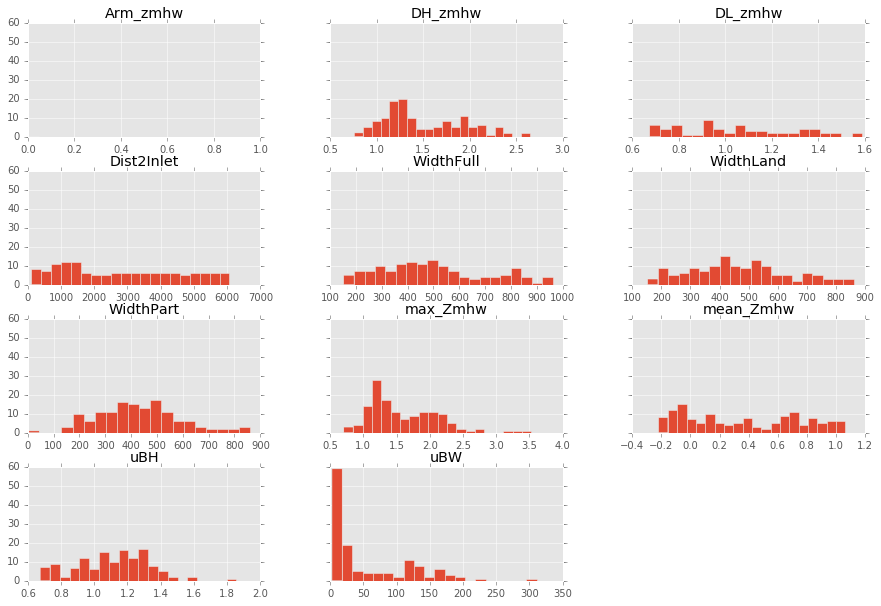

In [33]:
desccols = ['DL_zmhw', 'DH_zmhw', 'Arm_zmhw', 'uBW', 'uBH', 'Dist2Inlet', 
            'WidthPart', 'WidthLand', 'WidthFull', 'mean_Zmhw', 'max_Zmhw']

# Histograms
trans_df.hist(desccols, sharey=True, figsize=[15, 10], bins=20)
plt.show()
plt.close('all')

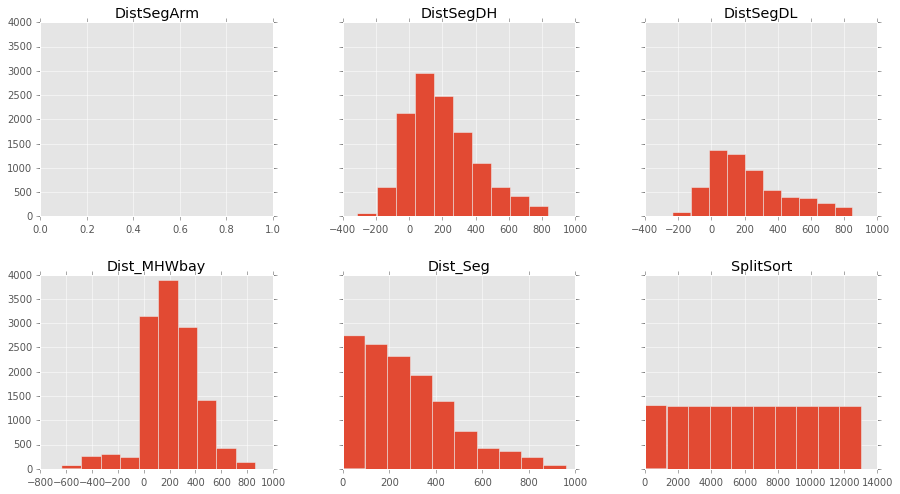

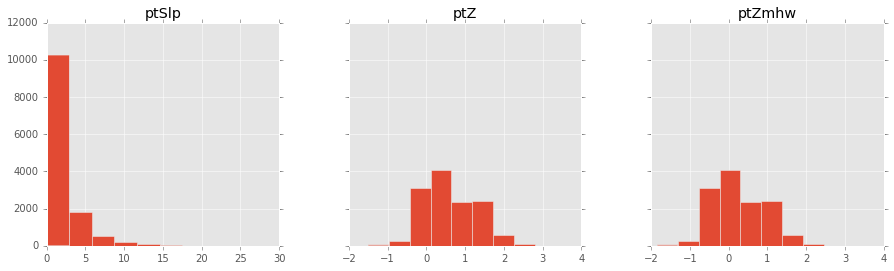

In [34]:
flds_dist = ['SplitSort', 'Dist_Seg', 'Dist_MHWbay', 'DistSegDH', 'DistSegDL', 'DistSegArm']
flds_z = ['ptZmhw', 'ptZ', 'ptSlp']
pts_df.loc[:,flds_dist+flds_z].describe()
pts_df.hist(flds_dist, sharey=True, figsize=[15, 8], layout=(2,3))
pts_df.hist(flds_z, sharey=True, figsize=[15, 4], layout=(1,3))
plt.show()
plt.close('all')

Transect ID ("sort_ID" 1-205): 140


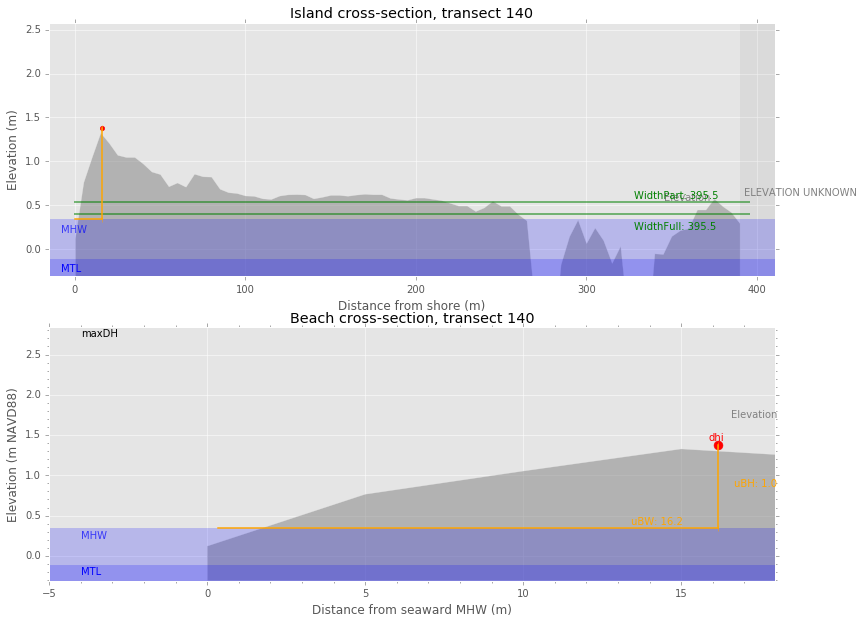

In [40]:
# Prompt for transect identifier (sort_ID) and get all points from that transect.
trans_in = int(input('Transect ID ("sort_ID" {:d}-{:d}): '.format(int(pts_df[tID_fld].head(1)), int(pts_df[tID_fld].tail(1)))))
pts_set = pts_df[pts_df[tID_fld] == trans_in]

# Plot
fig = plt.figure(figsize=(13,10))

# Plot the width of the island.
ax1 = fig.add_subplot(211)
try:
    fun.plot_island_profile(ax1, pts_set, sitevals['MHW'], sitevals['MTL'])
except TypeError as err:
    print('TypeError: {}'.format(err))
    pass

# Zoom in on the upper beach.
ax2 = fig.add_subplot(212)
try:
    fun.plot_beach_profile(ax2, pts_set, sitevals['MHW'], sitevals['MTL'], maxDH)
except TypeError as err:
    print('TypeError: {}'.format(err))
    pass 

# Display
plt.show()
plt.close('all')

## Outputs

### Transect-averaged
Output the transect-averaged metrics in the following formats:
- transects, unpopulated except for ID values, as gdb feature class
- transects, unpopulated except for ID values, as shapefile
- populated transects with fill values as gdb feature class
- populated transects with null values as gdb feature class
- populated transects with fill values as shapefile
- raster of beach width (__uBW__) by transect

In [41]:
# Load the dataframe
trans_df = pd.read_pickle(os.path.join(scratch_dir, trans_name+'_null.pkl'))

#### Vector format

In [42]:
# Create transect file with only ID values and geometry to publish.
trans_flds = ['TRANSECTID', 'TRANSORDER', 'DD_ID']
trans_4pub = fwa.JoinDFtoFC(trans_df.loc[:,trans_flds], extendedTrans, tID_fld, out_fc=sitevals['code']+'_trans')
out_shp = arcpy.FeatureClassToFeatureClass_conversion(trans_4pub, scratch_dir, sitevals['code']+'_trans.shp')
print("OUTPUT: {} in specified scratch_dir.".format(os.path.basename(str(out_shp))))

Created cobb_trans from input dataframe and extTrans file.
OUTPUT: cobb_trans.shp in specified scratch_dir.


In [43]:
# Create transect FC with fill values - Join values from trans_df to the transect FC as a new file.
trans_fc = fwa.JoinDFtoFC(trans_df, extendedTrans, tID_fld, out_fc=trans_name+'_fill')

# Create transect FC with null values
fwa.CopyFCandReplaceValues(trans_fc, fill, None, out_fc=trans_name+'_null', out_dir=home)

# Save final transect SHP with fill values
out_shp = arcpy.FeatureClassToFeatureClass_conversion(trans_fc, scratch_dir, trans_name+'_shp.shp')
print("OUTPUT: {} in specified scratch_dir.".format(os.path.basename(str(out_shp))))

Created cobb14_trans_fill from input dataframe and extTrans file.
OUTPUT: cobb14_trans_null
OUTPUT: cobb14_trans_shp.shp in specified scratch_dir.


#### Raster - beach width

In [44]:
# Create a template raster corresponding to the transects. 
if not arcpy.Exists(rst_transID):
    print("{} was not found so we will create the base raster.".format(os.path.basename(rst_transID)))
    outEucAll = arcpy.sa.EucAllocation(extTrans_tidy, maximum_distance=50, cell_size=cell_size, source_field=tID_fld)
    outEucAll.save(os.path.basename(rst_transID))

# Create raster of uBW values by joining trans_df to the template raster.
out_rst = fwa.JoinDFtoRaster(trans_df, os.path.basename(rst_transID), bw_rst, fill, tID_fld, 'uBW')

Cobb_rstTransID was not found so we will create the base raster.
OUTPUT: cobb14_ubw. Field "Value" is ID and "uBW" is beachwidth.


### 5-m points

Output the point metrics in the following formats:
- tabular, in CSV
- populated points with fill values as gdb feature class
- populated points with null values as gdb feature class
- populated points with fill values as shapefile

In [45]:
# Load the saved dataframes
pts_df4csv = pd.read_pickle(os.path.join(scratch_dir, pts_name+'_csv.pkl'))
pts_df = pd.read_pickle(os.path.join(scratch_dir, pts_name+'_null.pkl'))

#### Tabular format

In [46]:
# Save CSV in scratch_dir
csv_fname = os.path.join(scratch_dir, pts_name +'.csv')
pts_df4csv.to_csv(csv_fname, na_rep=fill, index=False)
print("OUTPUT: {} in specified scratch_dir.".format(os.path.basename(csv_fname)))

OUTPUT: cobb14_pts.csv in specified scratch_dir.


#### Vector format

In [47]:
# Convert pts_df to FC - automatically converts NaNs to fills (default fill is -99999)
pts_fc = fwa.DFtoFC_large(pts_df, out_fc=os.path.join(arcpy.env.workspace, pts_name+'_fill'), 
                          spatial_ref=utmSR, df_id=pID_fld, xy=["seg_x", "seg_y"])

# Save final FCs with null values
fwa.CopyFCandReplaceValues(pts_fc, fill, None, out_fc=pts_name+'_null', out_dir=home)

# Save final points as SHP with fill values
out_pts_shp = arcpy.FeatureClassToFeatureClass_conversion(pts_fc, scratch_dir, pts_name+'_shp.shp')
print("OUTPUT: {} in specified scratch_dir.".format(os.path.basename(str(out_pts_shp))))

Converting points DF to FC...
... converting dataframe to array... 
... converting array to feature class... 

OUTPUT: cobb14_pts_fill
Duration: 0:1:46.8 seconds
OUTPUT: cobb14_pts_null
OUTPUT: cobb14_pts_shp.shp in specified scratch_dir.


### Report field values

In [48]:
print('{}{} -- Number of points in dataset: {}'.format(site, year, pts_df4csv.shape))
for fld in pts_df4csv.columns:
    if fld in ['GeoSet', 'SubType', 'VegDens', 'VegType', 'Construction', 'Development', 'Nourishment', 'ub_feat']:
        print('{} values: {}'.format(fld, '  |  '.join(str(x) for x in pts_df4csv.loc[:,fld].unique())))
    else:
        if not any(pd.isnull(pts_df4csv.loc[:,fld])):
            mn = min(pts_df4csv.loc[:,fld])
        else:
            mn = -99999
        mx = np.max(pts_df4csv.loc[:,fld])
        print('{} min|max: {}  |  {}'.format(fld, mn, mx))

Cobb2014 -- Number of points in dataset: (13017, 54)
SplitSort min|max: 0  |  13016
seg_x min|max: -99999.0  |  434713.8192999996
seg_y min|max: -99999.0  |  4133440.6898
Dist_Seg min|max: -99999.0  |  959.3987163730674
Dist_MHWbay min|max: -99999.0  |  861.4368343658393
DistSegDH min|max: -99999.0  |  837.5319743744599
DistSegDL min|max: -99999.0  |  849.5500014605107
DistSegArm min|max: -99999.0  |  -99999.0
ptZ min|max: -99999.0  |  3.869490623474121
ptSlp min|max: -99999.0  |  29.142112731933594
ptZmhw min|max: -99999.0  |  3.5294907093048096
GeoSet values: -99999.0  |  1.0  |  2.0  |  3.0  |  4.0  |  5.0  |  6.0
SubType values: -99999  |  4444.0  |  {1111, 2222}  |  {1111, 3333}  |  3333.0
VegDens values: -99999  |  111.0  |  {111, 222}  |  {222, 333}  |  {333, 444}
VegType values: -99999  |  11.0  |  {11, 22}  |  {22, 33}  |  {33, 44}
sort_ID min|max: 1.0  |  205.0
TRANSORDER min|max: -99999.0  |  -99999.0
TRANSECTID min|max: -99999.0  |  -99999.0
DD_ID min|max: 160001  |  160205